In [10]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import sys
sys.path.append("/Users/Max/Documents/Studium/HiWi/HiWi_Fernerkundung/FlightPhases/")

import FlightPhaseTools as fpt
from ResearchFlight import ResearchFlight
from ResearchFlightSegment import ResearchFlightSegment

# Load data into xarray datasets using typhon FileSet objects.

In [11]:
bahamas = xr.open_dataset('/Users/Max/Documents/Studium/HiWi/HiWi_Fernerkundung/FlightPhases/data/bahamas_20200124_v0.4.nc')
dropsondes = xr.open_dataset('/Users/Max/Documents/Studium/HiWi/HiWi_Fernerkundung/FlightPhases/data/dropsondes_20200124_v0.4.nc')

# Determine the timestamps of the different flight phases using the FlightPhaseTools module.

In [12]:
takeoff = 0
touchdown = len(bahamas['time']) - 1

#circles
enter_c1 = fpt.ds_timestamp_ind(bahamas, dropsondes,  0)
exit_c1  = fpt.ds_timestamp_ind(bahamas, dropsondes, 11)
enter_c2 = fpt.ds_timestamp_ind(bahamas, dropsondes, 12)
exit_c2  = fpt.ds_timestamp_ind(bahamas, dropsondes, 24)
enter_c3 = fpt.ds_timestamp_ind(bahamas, dropsondes, 25)
exit_c3  = fpt.ds_timestamp_ind(bahamas, dropsondes, 36)
enter_c4 = fpt.ds_timestamp_ind(bahamas, dropsondes, 37)
exit_c4  = fpt.ds_timestamp_ind(bahamas, dropsondes, 48)
enter_c5 = fpt.ds_timestamp_ind(bahamas, dropsondes, 49)
exit_c5  = fpt.ds_timestamp_ind(bahamas, dropsondes, 60)
enter_c6 = fpt.ds_timestamp_ind(bahamas, dropsondes, 61)
exit_c6  = fpt.ds_timestamp_ind(bahamas, dropsondes, 72)

#leg1
max_roll_before_leg1 = fpt.max_timestamp_ind(bahamas, 'roll', 
                       slice('2020-01-24T16:45:00', '2020-01-24T17:15:00'), order=1000)

enter_leg1 = fpt.find_first_value_after_ts_ind(bahamas, 'roll', max_roll_before_leg1, 0., 0.05)

min_roll_after_leg1 = fpt.min_timestamp_ind(bahamas, 'roll', 
                      slice('2020-01-24T17:15:00', '2020-01-24T17:45:00'), order=1000)

exit_leg1 = fpt.find_first_value_before_ts_ind(bahamas, 'roll', min_roll_after_leg1, 0., 0.05)


#leg2
max_roll_before_leg2 = fpt.max_timestamp_ind(bahamas, 'roll', 
                       slice('2020-01-24T17:15:00', '2020-01-24T17:45:00'), order=1000)

enter_leg2 = fpt.find_first_value_after_ts_ind(bahamas, 'roll', max_roll_before_leg2, 0., 0.05)

bahamas["altitude_dt"] = (['time'], np.append(np.diff(bahamas["altitude"]),0))

min_dzdt_after_leg2 = fpt.min_timestamp_ind(bahamas, 'altitude_dt', 
                      slice('2020-01-24T18:00:00', '2020-01-24T18:15:00'), order=1000)

exit_leg2 = fpt.find_first_value_before_ts_ind(bahamas, 'altitude_dt', min_dzdt_after_leg2, 0., 0.05)

#lidar_cal
enter_lidar_cal = fpt.find_first_value_after_ts_ind(bahamas, 'altitude_dt', min_dzdt_after_leg2, 0., 0.05)

min_dzdt_after_leg3 = fpt.min_timestamp_ind(bahamas, 'altitude_dt', 
                      slice('2020-01-24T18:15:00', '2020-01-24T18:30:00'), order=1000)

exit_lidar_cal = fpt.find_first_value_before_ts_ind(bahamas, 'altitude_dt', min_dzdt_after_leg3, 0., 0.05)



ts_ind_list = [takeoff, touchdown, enter_c1, exit_c1, enter_c2, 
               exit_c2, enter_c3, exit_c3, enter_c4, exit_c4, 
               enter_c5, exit_c5, enter_c6, exit_c6, enter_leg1,
               exit_leg1, enter_leg2, exit_leg2, enter_lidar_cal, exit_lidar_cal]
label_list = ["takeoff", "touchdown", "enter_c1", "exit_c1", 
              "enter_c2", "exit_c2", "enter_c3", "exit_c3", 
              "enter_c4", "exit_c4", "enter_c5", "exit_c5", 
              "enter_c6", "exit_c6","enter_leg1", "exit_leg1",
              "enter_leg2", "exit_leg2", "enter_lidar_cal", "exit_lidar_cal"]

In [3]:
#create markers for every dropsonde
#only for checking segments
ts_ind_list = []
label_list = np.arange(1,len(dropsondes["launch_time"])+1)
for i in range(len(dropsondes["launch_time"])):
    ts_ind_list.append(fpt.ds_timestamp_ind(bahamas, dropsondes,  i))

# Create basic timeseries of bahamas data with markers for determined timestamps to manually evaluate the validity of the timestamps.

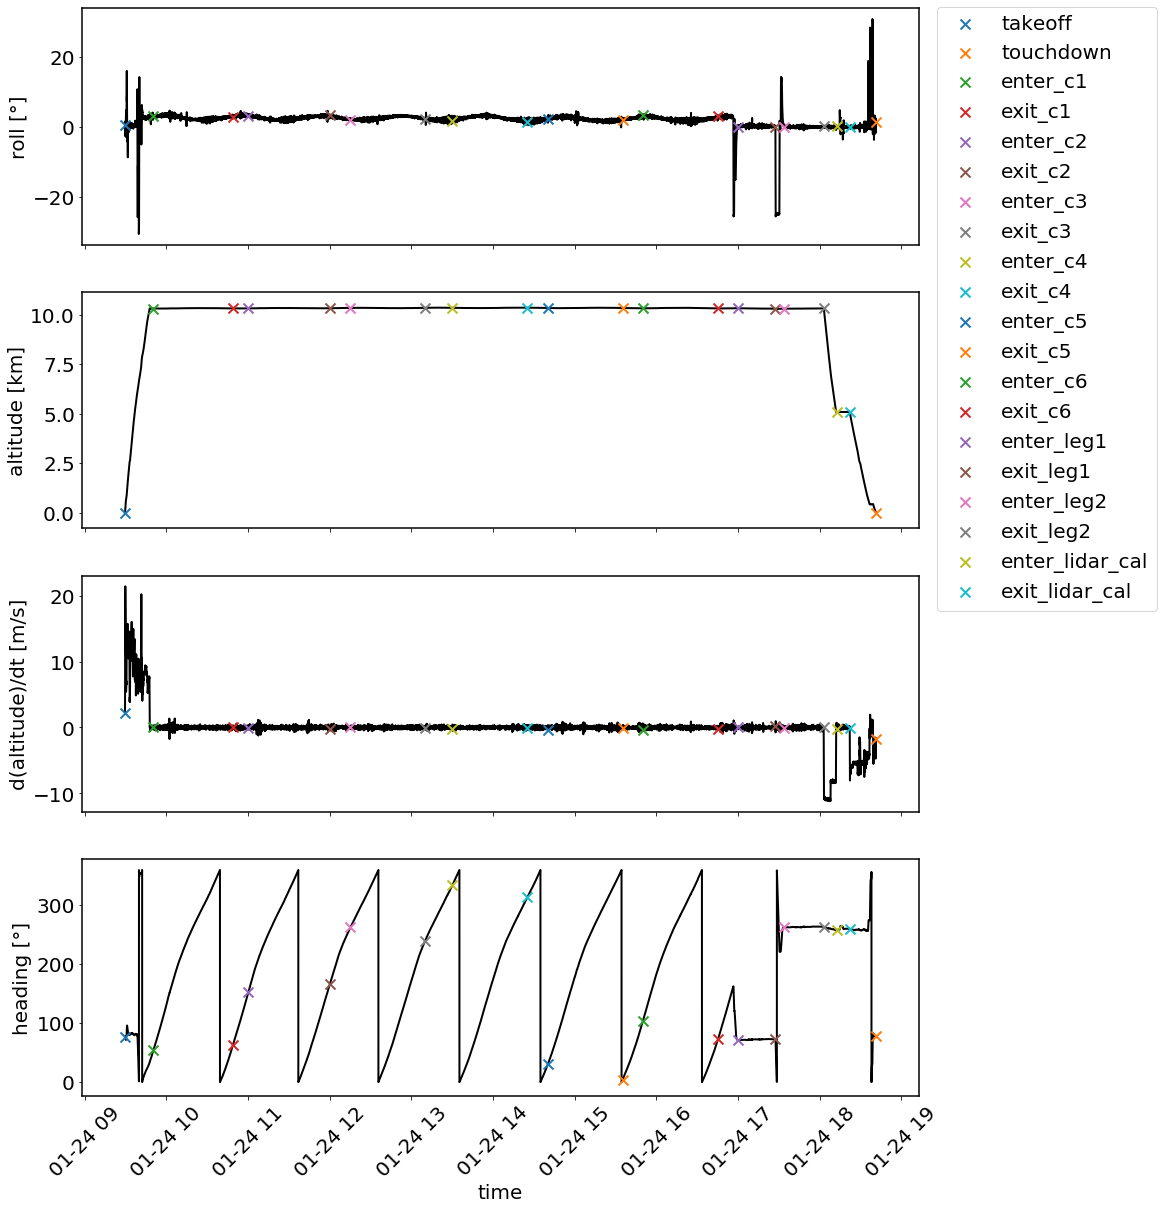

In [13]:
fig, ax = fpt.plot_bahamas_timeseries(bahamas, ts_ind_list, label_list)

# Create a ResearchFlight object to represent the flight meta data.

In [14]:
RF03 = ResearchFlight(name=f"RF{bahamas.attrs['flight_number']}",
                      mission=bahamas.attrs['mission'],
                      flight_id='HALO-0124',
                      contacts=[
                          {
                              'name': 'Marc Prange', 
                              'email': 'marc.prange@uni-hamburg.de',
                              'tags': ['dataset creator'],
                          },
                          {
                              'name': 'Bjorn Stevens',
                              'email': 'bjorn.stevens@mpimet.mpg.de',
                              'tags': ['flight PI']
                          }
                      ],
                      date=fpt.dt64_to_dt(bahamas['time'][takeoff].values).date(),
                      flight_report='https://observations.ipsl.fr/aeris/eurec4a-data/REPORTS/HALO/2020/20200124/HALO-0124.pdf',
                      takeoff=fpt.dt64_to_dt(bahamas['time'][takeoff].values),
                      landing=fpt.dt64_to_dt(bahamas['time'][touchdown].values),
                      events=[],
                      remarks=['Circle pattern, in the end excursion towards NTAS.',
                               'Deeper convection in the SE circle, spreading cold pools and stratiform clouds.'],
)

# Store the flight phase information in ResearchFlightSegment objects.

In [15]:
circle1 = ResearchFlightSegment(kind='circle',
                                name='c1',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c1].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c1].values)
                               )
circleBreak1to2 = ResearchFlightSegment(kind='circle_break',
                                        name='cb1to2',
                                        start=fpt.dt64_to_dt(bahamas["time"][exit_c1].values),
                                        end=fpt.dt64_to_dt(bahamas['time'][enter_c2].values)
                                       )
circle2 = ResearchFlightSegment(kind='circle',
                                name='c2',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c2].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c2].values)
                               )
circleBreak2to3 = ResearchFlightSegment(kind='circle_break',
                                        name='cb2to3',
                                        start=fpt.dt64_to_dt(bahamas["time"][exit_c2].values),
                                        end=fpt.dt64_to_dt(bahamas['time'][enter_c3].values)
                                       ) 
circle3 = ResearchFlightSegment(kind='circle',
                                name='c3',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c3].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c3].values)
                               )
circleBreak3to4 = ResearchFlightSegment(kind='circle_break',
                                        name='cb3to4',
                                        start=fpt.dt64_to_dt(bahamas["time"][exit_c3].values),
                                        end=fpt.dt64_to_dt(bahamas['time'][enter_c4].values)
                                       ) 
circle4 = ResearchFlightSegment(kind='circle',
                                name='c4',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c4].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c4].values)
                               )
circleBreak4to5 = ResearchFlightSegment(kind='circle_break',
                                        name='cb4to5',
                                        start=fpt.dt64_to_dt(bahamas["time"][exit_c4].values),
                                        end=fpt.dt64_to_dt(bahamas['time'][enter_c5].values)
                                       )
circle5 = ResearchFlightSegment(kind='circle',
                                name='c5',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c5].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c5].values)
                               )
circleBreak5to6 = ResearchFlightSegment(kind='circle_break',
                                        name='cb5to6',
                                        start=fpt.dt64_to_dt(bahamas["time"][exit_c5].values),
                                        end=fpt.dt64_to_dt(bahamas['time'][enter_c6].values)
                                       )                                    
circle6 = ResearchFlightSegment(kind='circle',
                                name='c6',
                                start=fpt.dt64_to_dt(bahamas["time"][enter_c6].values),
                                end=fpt.dt64_to_dt(bahamas['time'][exit_c6].values)
                               )
leg1 = ResearchFlightSegment(kind='straight_leg',
                             name='leg1_outbound_NTAS',
                             start=fpt.dt64_to_dt(bahamas["time"][enter_leg1].values),
                             end=fpt.dt64_to_dt(bahamas['time'][exit_leg1].values)
                            )
leg2 = ResearchFlightSegment(kind='straight_leg',
                             name='leg2_inbound_NTAS',
                             start=fpt.dt64_to_dt(bahamas["time"][enter_leg2].values),
                             end=fpt.dt64_to_dt(bahamas['time'][exit_leg2].values)
                            )
lidar_cal = ResearchFlightSegment(kind='lidar_calibration',
                                  name='lidar_cal',
                                  start=fpt.dt64_to_dt(bahamas["time"][enter_lidar_cal].values),
                                  end=fpt.dt64_to_dt(bahamas['time'][exit_lidar_cal].values)
                                 )

# Append the flight segments to the ResearchFlight object and save the object content to a .yaml file.

In [16]:
RF03.to_dictionary()

{'name': 'RF03',
 'mission': 'EUREC4A',
 'flight_id': 'HALO-0124',
 'contacts': [{'name': 'Marc Prange',
   'email': 'marc.prange@uni-hamburg.de',
   'tags': ['dataset creator']},
  {'name': 'Bjorn Stevens',
   'email': 'bjorn.stevens@mpimet.mpg.de',
   'tags': ['flight PI']}],
 'date': datetime.date(2020, 1, 24),
 'flight_report': 'https://observations.ipsl.fr/aeris/eurec4a-data/REPORTS/HALO/2020/20200124/HALO-0124.pdf',
 'takeoff': datetime.datetime(2020, 1, 24, 9, 29, 30),
 'landing': datetime.datetime(2020, 1, 24, 18, 41, 13),
 'events': [],
 'remarks': ['Circle pattern, in the end excursion towards NTAS.',
  'Deeper convection in the SE circle, spreading cold pools and stratiform clouds.'],
 'segments': []}

In [17]:
RF03.append_segments([circle1, circleBreak1to2, 
                      circle2, circleBreak2to3,
                      circle3, circleBreak3to4, 
                      circle4, circleBreak4to5,
                      circle5, circleBreak5to6, 
                      circle6, leg1, leg2, lidar_cal])

In [18]:
RF03.to_yaml(filename='/Users/Max/Documents/Studium/HiWi/HiWi_Fernerkundung/FlightPhases/halo-flight-phase-separation-1/flight_phase_files/HALO_RF03_20200124_info.yaml')